In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs (1=INFO, 2=WARNING, 3=ERROR)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disables GPU and forces TensorFlow to use CPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'  # Prevent any GPU initialization

import tensorflow as tf


E0000 00:00:1732538558.286070    6900 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732538558.290327    6900 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
# set parameter
image_size = 256
batch_size = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (image_size , image_size),
    batch_size = batch_size
)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
print(f"Classes found: {classes}")

Classes found: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


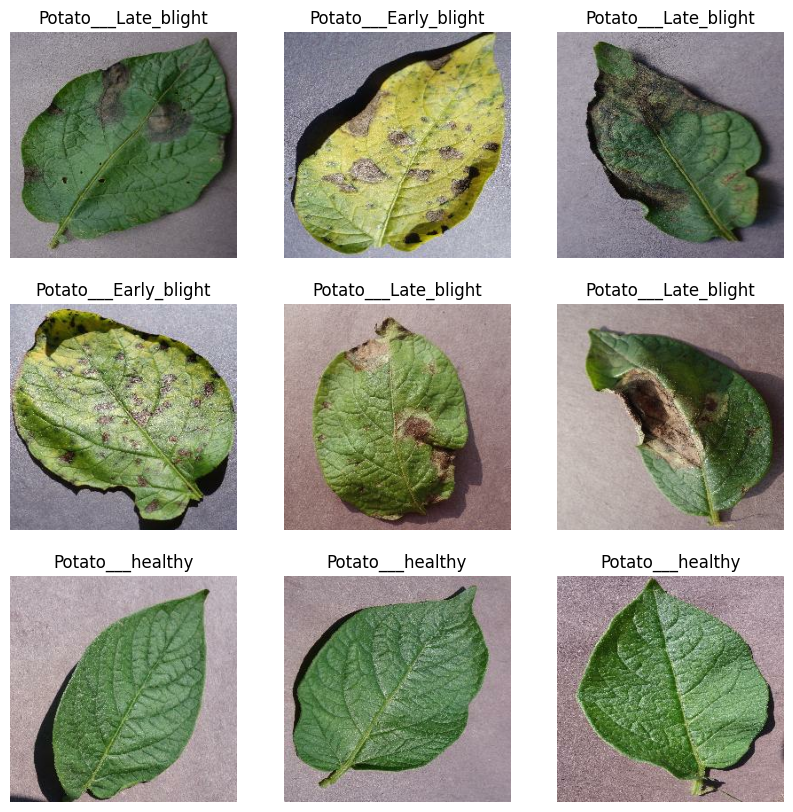

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")
plt.show()

In [10]:
# function to split

import tensorflow as tf

def split_dataset(dataset, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    """
    Splits a TensorFlow dataset into training, validation, and testing datasets.

    Parameters:
    - dataset (tf.data.Dataset): The dataset to split.
    - train_split (float): Proportion of the dataset to use for training.
    - val_split (float): Proportion of the dataset to use for validation.
    - test_split (float): Proportion of the dataset to use for testing.
    - shuffle (bool): Whether to shuffle the dataset before splitting.
    - shuffle_size (int): Buffer size for shuffling.

    Returns:
    - train_ds (tf.data.Dataset): Training dataset.
    - val_ds (tf.data.Dataset): Validation dataset.
    - test_ds (tf.data.Dataset): Testing dataset.
    """
    assert train_split + val_split + test_split == 1.0, "Splits must sum to 1.0"

    # Calculate dataset sizes
    dataset_size = sum(1 for _ in dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size, seed=42, reshuffle_each_iteration=False)

    # Split the dataset
    train_ds = dataset.take(train_size)
    remaining_ds = dataset.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds


In [11]:
# Assuming `dataset` is your tf.data.Dataset
train_ds, val_ds, test_ds = split_dataset(
    dataset,
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    shuffle=True,
    shuffle_size=1000
)

# Print sizes of the datasets to verify
print(f"Training size: {len(list(train_ds))}")
print(f"Validation size: {len(list(val_ds))}")
print(f"Testing size: {len(list(test_ds))}")


Training size: 47
Validation size: 10
Testing size: 11


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

# Training set: Shuffle, batch, and prefetch
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Validation set: Cache, batch, and prefetch
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Test set: Cache, batch, and prefetch
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)


In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),  # Resize to the target size
    layers.Rescaling(1./255)                 # Rescale pixel values to [0, 1]
])


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),  # Randomly flip images
    layers.RandomRotation(0.2),                   # Randomly rotate images
    layers.RandomZoom(0.2),                       # Randomly zoom in
    layers.RandomContrast(0.2),                   # Randomly adjust contrast
])
